In [27]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
import warnings
import itertools
import numpy as np
import sys
plt.style.use('fivethirtyeight')

## Loading Air Passengers Data

In [16]:
df = pd.read_csv('AirPassengers.csv')

# Converting Month to Date
df['date'] = pd.to_datetime(df.Month, format='%Y-%m')

# Drop Month column
df = df.drop('Month', axis=1)

In [18]:
# Set the 'Month' attribute as Index

df = df.set_index('date')
df.head()

,#Passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [19]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)

This confirms that our index has been identified as DatetimeIndex

In [20]:
df.isnull().sum()

#Passengers    0
dtype: int64

## Visualizing Data

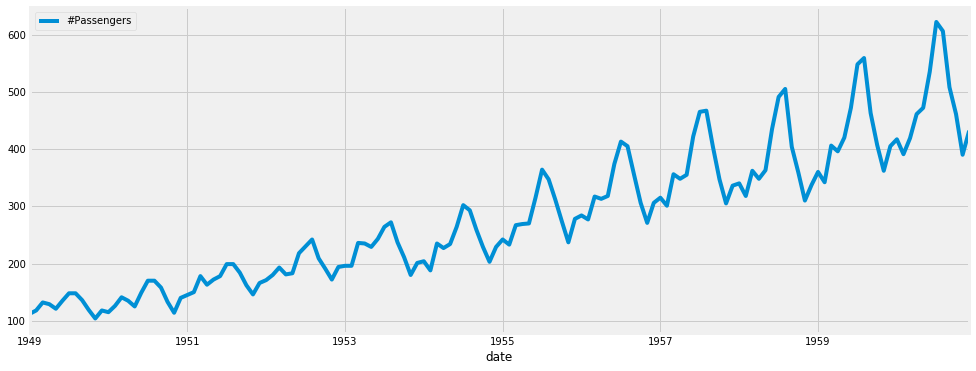

In [21]:
df.plot(figsize=(15, 6))
plt.show()

This shows there is an upward trend, to visualize more accurately let's decompose the data

In [22]:
rcParams['figure.figsize'] = 11, 9

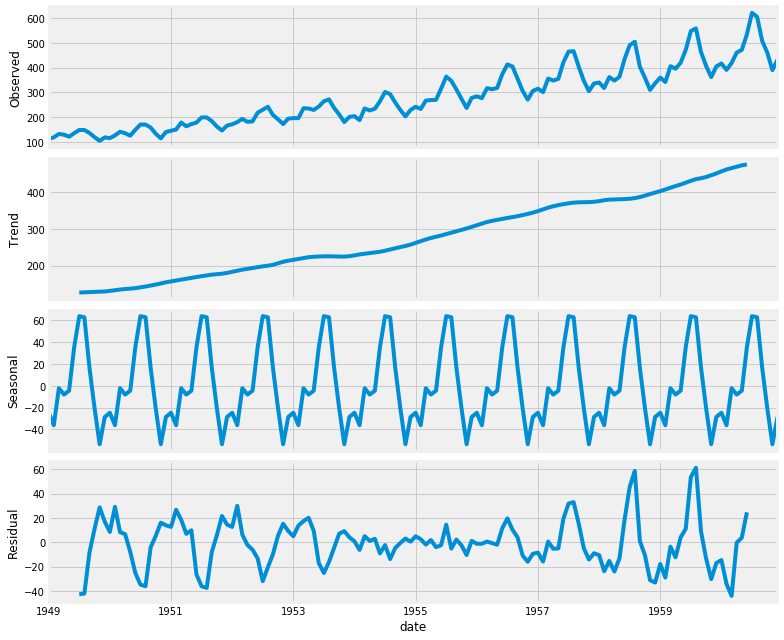

In [23]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

Here we can observe seasonality as well, but there are still some patterns left in the Residual, let's see the results with the multiplicative model

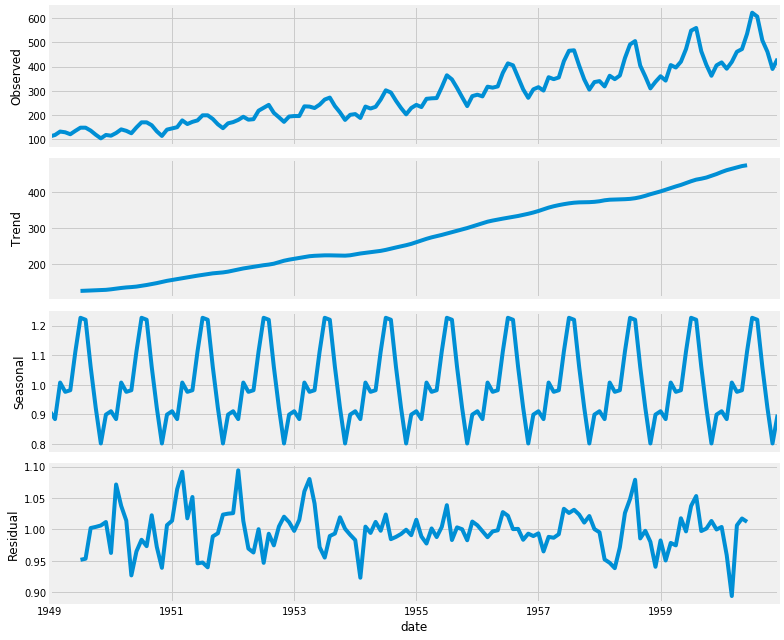

In [24]:
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Check for Stationarity

Using the Dickey-Fuller test for checking stationarity

In [80]:
from statsmodels.tsa.stattools import adfuller
rcParams['figure.figsize'] = 15, 6

In [72]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

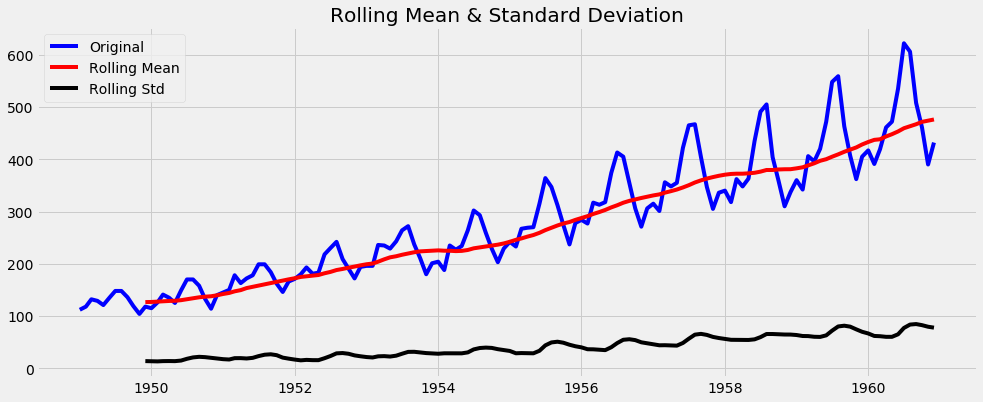

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [81]:
test_stationarity(df['#Passengers'])

Since the mean is not constant, it shows that the timeseries is not stationary

## Converting into a Stationary Time Series

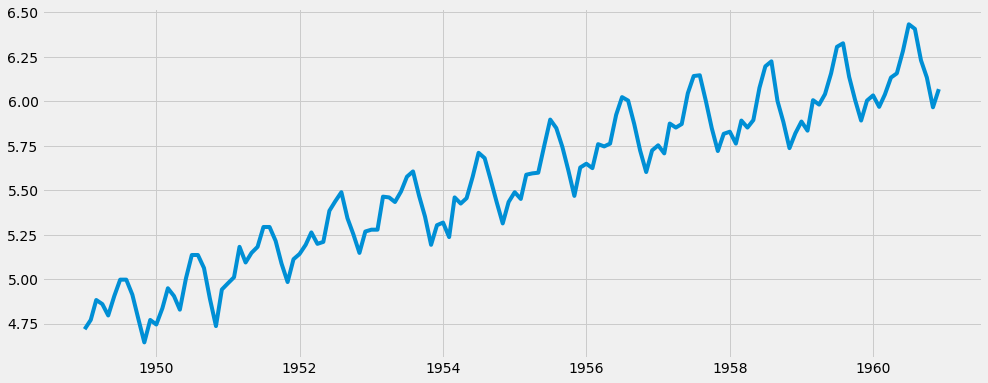

In [82]:
# 1. Transforming by Taking log

df_log = np.log(df)
plt.plot(df_log)

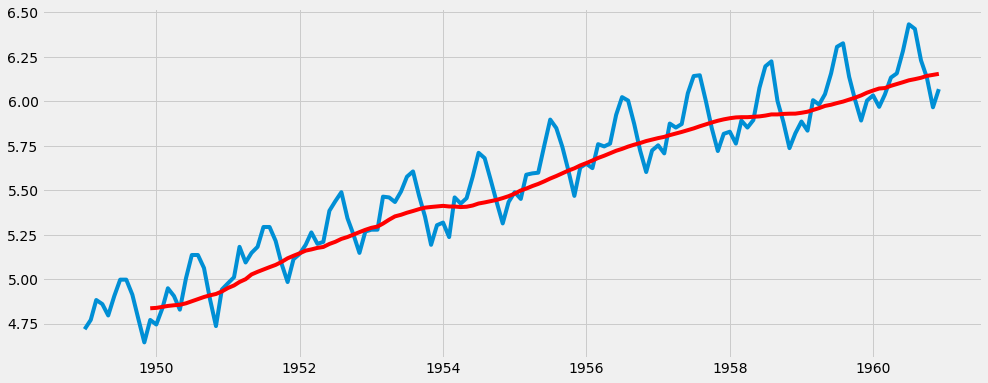

In [83]:
# 2. Taking moving average

moving_avg = df_log.rolling(12).mean()
plt.plot(df_log)
plt.plot(moving_avg, color='red')

In [84]:
# 3. Subtract the rolling mean from the original series

df_log_moving_avg_diff = df_log - moving_avg

In [85]:
df_log_moving_avg_diff.head(12)

,#Passengers
date,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [86]:
# Drop NaN values
df_log_moving_avg_diff.dropna(inplace=True)

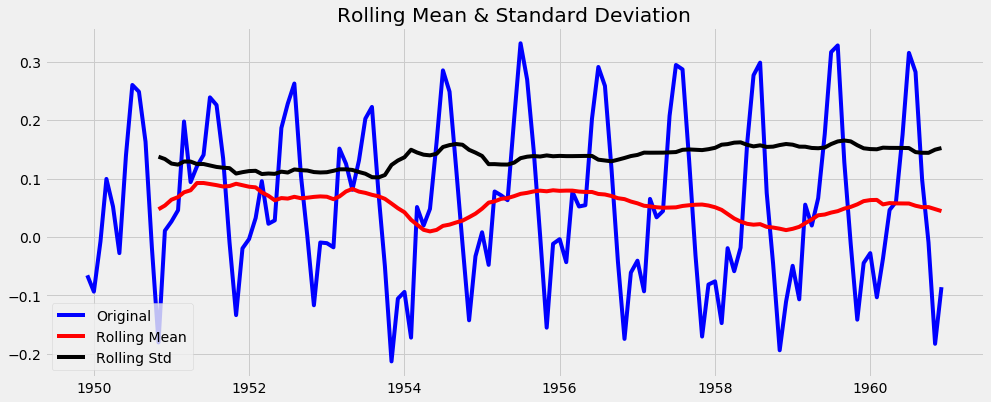

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [87]:
# Now check stationarity of transformed time series

test_stationarity(df_log_moving_avg_diff['#Passengers'])

There are a lot of different ways to remove trend and seasonality, for now, I will move forward just with the method used above

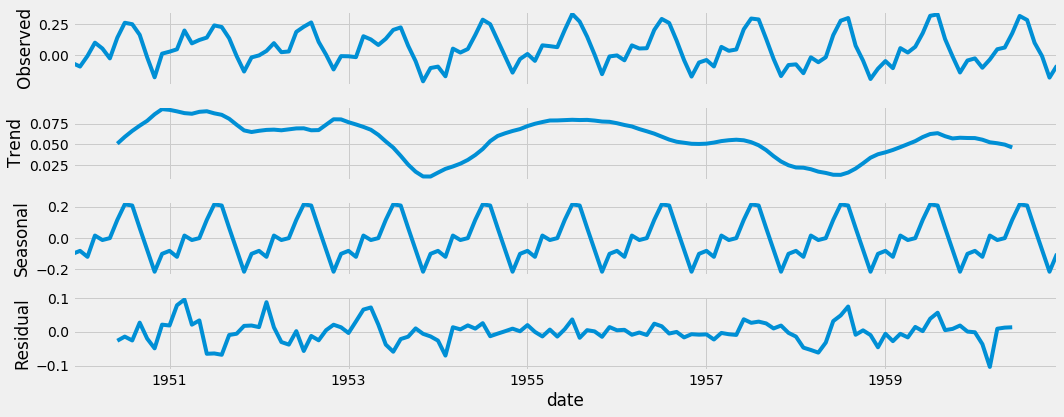

In [89]:
decomposition = sm.tsa.seasonal_decompose(df_log_moving_avg_diff, model='additive')
fig = decomposition.plot()
plt.show()

This decomposition shows that there is no more trend in the timeseries

## ARIMA Time Series Model

First we need to identify the p,d,q parameters
Using Grid Search to find the optimal values of parameters

In [90]:
# Generally p,d,q can take either 0 or 1 therefore
p = d = q = range(0, 2)

# Generate all different combinations of p,d,q
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p,d,q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [91]:
# We select the combination that yields the lowest AIC value

warnings.filterwarnings("ignore")

min_aic = sys.maxsize
best_combo = (0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = sm.tsa.statespace.SARIMAX(df_log_moving_avg_diff,
                                         order=param,
                                         seasonal_order=param_seasonal,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
        results = model.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        if min_aic > results.aic:
            min_aic = results.aic
            best_combo = (param, param_seasonal)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-131.8830595561683
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-203.31364052223506
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-361.7292405884373
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-372.56719556660465
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-364.8930664648979
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-398.6487547990457
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-368.30168390699066
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-366.2182538883545
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-230.8783694315135
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-279.8888615298131
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-396.94571441883846
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-401.3939043795448
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-401.60509516907194
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-431.6481298364754
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-399.41457622691337
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-392.546102800207
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-211.59241733070712
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-286.

In [92]:
best_combo, min_aic

(((1, 0, 0), (1, 0, 1, 12)), -452.3986100032851)

Hence we choose the ARIMA(1,0,0)(1,0,1)12 Model

In [93]:
# Fitting an SARIMAX model on the obtained parameters

model = sm.tsa.statespace.SARIMAX(df_log_moving_avg_diff,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6113      0.064      9.599      0.000       0.486       0.736
ar.S.L12       0.9954      0.020     51.021      0.000       0.957       1.034
ma.S.L12      -0.5826      0.116     -5.007      0.000      -0.811      -0.355
sigma2         0.0012      0.000      9.346      0.000       0.001       0.001


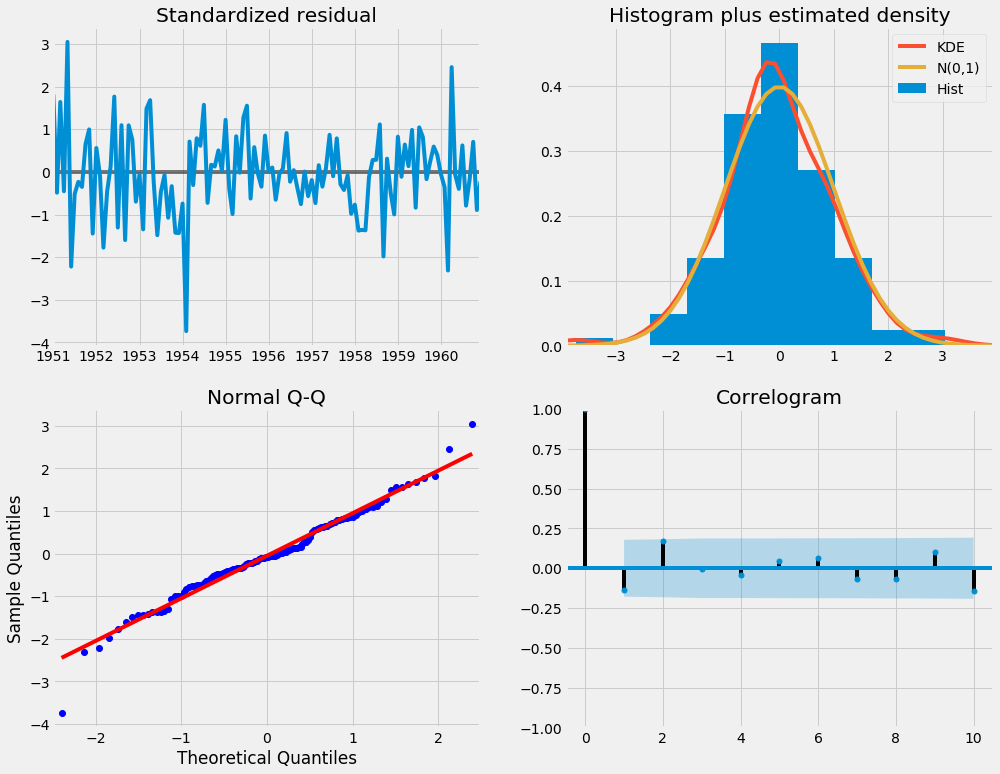

In [94]:
# Generating model diagnostics

results.plot_diagnostics(figsize=(15, 12))
plt.show()

Residuals are normally distributed due to
- KDE line follows closely with N(0,1)
- QQ-Plot shows distribution follows the trend line
- Correlogram shows low correlations

In [155]:
# Validating one-step ahead forecasts starting from 1957-01-01

pred = results.get_prediction(start=pd.to_datetime('1957-01-01'), dynamic=False)
pred_ci = pred.conf_int()

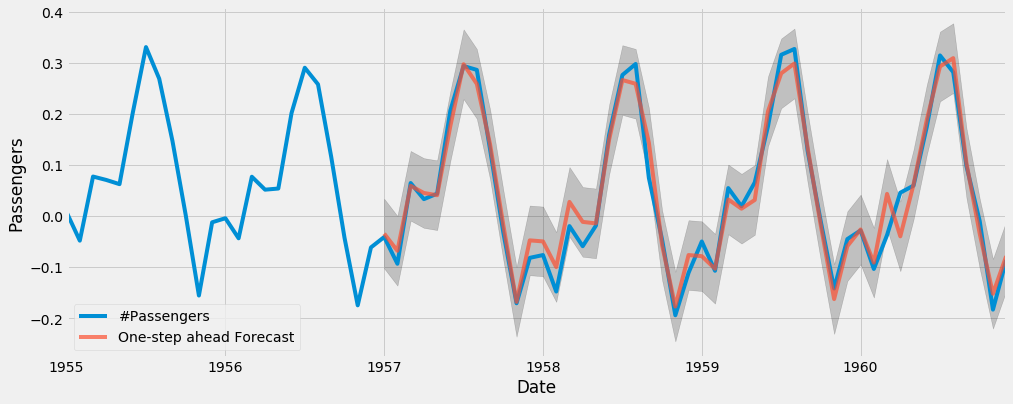

In [156]:
ax = df_log_moving_avg_diff['1955':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()

plt.show()

In [104]:
# Compute the mean squared error

df_forecasted = pred.predicted_mean
df_truth = df_log_moving_avg_diff['1957-01-01':]
df_truth = df_truth.T.squeeze()

mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 5)))

The Mean Squared Error is 0.00089


In [98]:
# Validating Dynamic forecasts starting from 1957-01-01

pred_dynamic = results.get_prediction(start=pd.to_datetime('1957-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

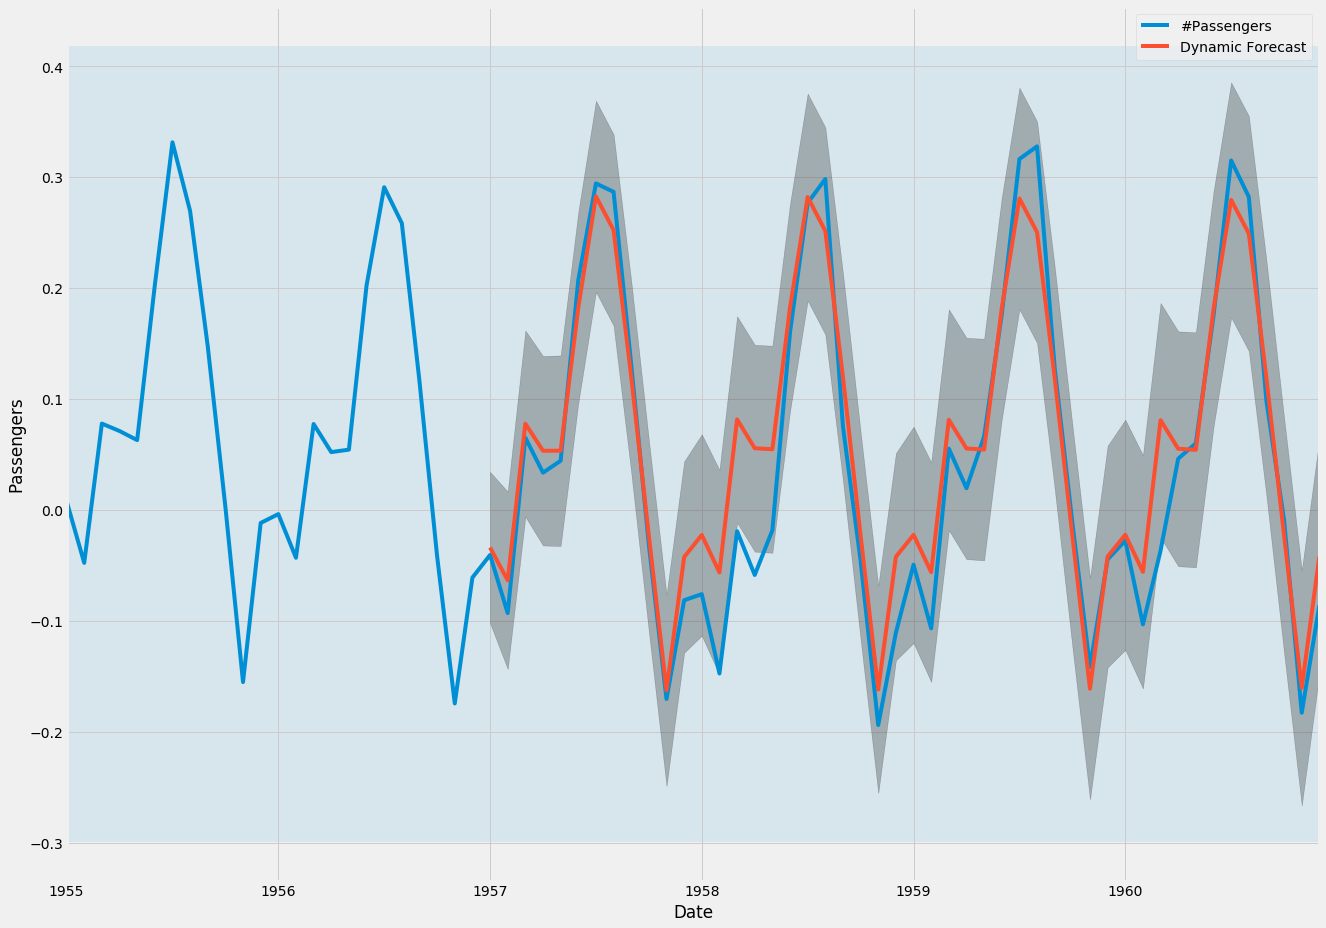

In [99]:
# Plot the actual and predicted forecast values starting from 1998-01-01

ax = df_log_moving_avg_diff['1955':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1955-01-01'), df_log_moving_avg_diff.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

plt.legend()
plt.show()

In [103]:
# Compute the mean squared error
df_forecasted = pred_dynamic.predicted_mean
df_truth = df_log_moving_avg_diff['1957-01-01':]
df_truth = df_truth.T.squeeze()

mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 5)))

The Mean Squared Error is 0.00189


In [105]:
# Forecast future values

# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

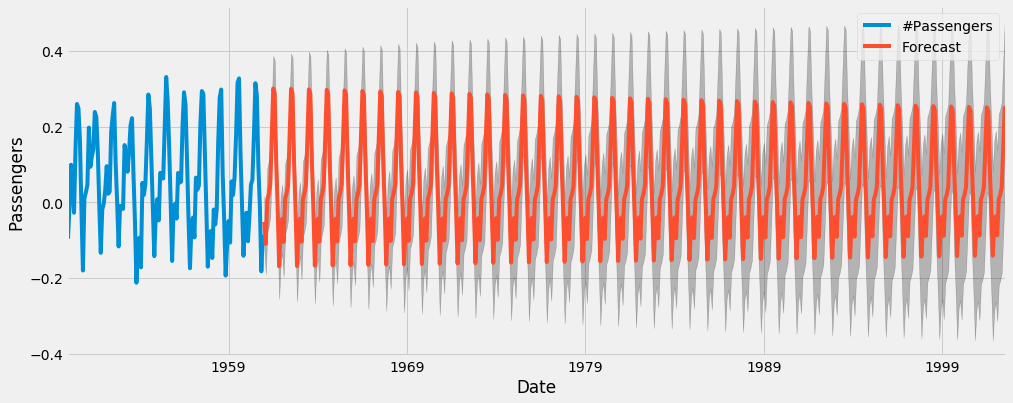

In [111]:
ax = df_log_moving_avg_diff.plot(label='observed', figsize=(15, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

plt.legend()
plt.show()